In [5]:
import re
import string
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tungc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tungc\AppData\Roaming\nltk_data...


True

In [4]:
import zipfile
import os

# Đường dẫn đến tệp zip
zip_file_path = 'archive.zip'

# Đường dẫn đến thư mục đích để giải nén
extract_to_path = 'emotional_data'

# Giải nén tệp zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)


In [31]:
df_train = pd.read_csv('emotional_data/train.txt', names=['sentence', 'label'], sep=';')
df_test = pd.read_csv('emotional_data/test.txt', names=['sentence', 'label'], sep=';')
df_val = pd.read_csv('emotional_data/val.txt', names=['sentence', 'label'], sep=';')

In [32]:
df = pd.concat([df_train, df_test])
df = pd.concat([df, df_val])

df

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


<Axes: xlabel='label', ylabel='count'>

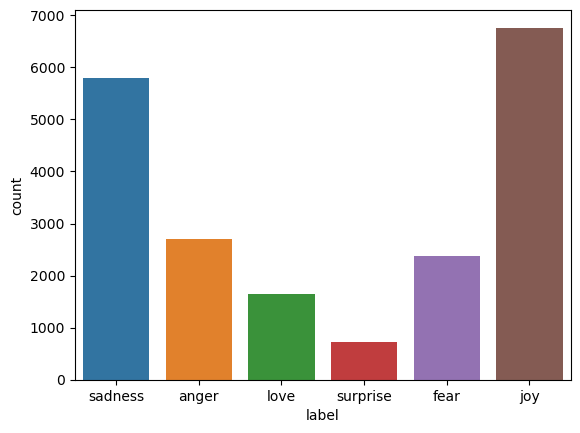

In [33]:
sns.countplot(x='label', data=df)

19239


<Axes: xlabel='label', ylabel='count'>

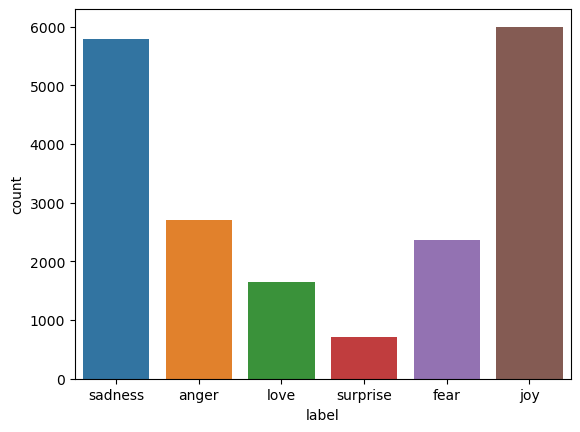

In [81]:
balance_length = 6000

# Lọc các nhãn khác nhau
df_sadness = df[df['label'] == 'sadness']
df_fear = df[df['label'] == 'fear']
df_surprise = df[df['label'] == 'surprise']
df_anger = df[df['label'] == 'anger']
df_love = df[df['label'] == 'love']
df_joy = df[df['label'] == 'joy']

# Sử dụng pd.concat thay cho append
new_df = pd.concat([
    df_sadness[:balance_length],
    df_anger, 
    df_love,
    df_surprise,
    df_fear,
    df_joy[:balance_length]
])

# Kiểm tra độ dài của DataFrame mới
print(len(new_df))

# Vẽ biểu đồ countplot
sns.countplot(x='label', data=new_df)


In [82]:
category = pd.get_dummies(new_df['label'])
new_df = pd.concat([new_df, category], axis=1)
new_df = new_df.drop(columns='label')
new_df

,sentence,anger,fear,joy,love,sadness,surprise
0,i didnt feel humiliated,False,False,False,False,True,False
1,i can go from feeling so hopeless to so damned...,False,False,False,False,True,False
5,ive been feeling a little burdened lately wasn...,False,False,False,False,True,False
10,i feel like i have to make the suffering i m s...,False,False,False,False,True,False
13,i feel low energy i m just thirsty,False,False,False,False,True,False
...,...,...,...,...,...,...,...
1831,i feel virtuous and tough when i wear a hat je...,False,False,True,False,False,False
1834,i feel so eager to prove to my friend that im ...,False,False,True,False,False,False
1839,i breathe into the feelings in my body resisti...,False,False,True,False,False,False
1840,ill likely post more on those later but feel f...,False,False,True,False,False,False


In [83]:
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

puncts = string.punctuation
replace_puncts = {'`': "'", '′': "'", '“':'"', '”': '"', '‘': "'"}

strip_chars = [',', '.', '"', ':', ')', '(', '-', '|', ';', "'", '[', ']', '>', '=', '+', '\\', '•',  '~', '@',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', '£']

print(sw)

custom_sw = list(set([word.replace("'", "") for word in sw]))
print(custom_sw)

sw = custom_sw+sw
sw = list(set(sw))
sw.sort()
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [84]:
def clean_text(text):
  text = str(text)
  text_stopword = [word.lower() for word in text.split() if word.lower() not in sw and len(word.lower()) > 2]  #
  text_stopword = " ".join(text_stopword)

  x = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", text_stopword)

  for key, value in replace_puncts.items():
    x = x.replace(key, f' {value} ')

  for punct in strip_chars:
    x = x.replace(punct, ' ')

  for punct in puncts:
    x = x.replace(punct, f' {punct} ')

  x = x.replace(" '", " ")
  x = x.replace("' ", " ")
  x = x.strip()
  return x

def lemm(text):
    text = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(text)

def text_processing(X):
    X=X.apply(clean_text)
    X=X.apply(lemm)
    return X

In [85]:
x = text_processing(new_df['sentence'])
y = new_df[['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']].values

x_clean = x.values
x_clean

array(['feel humiliated',
       'feeling hopeless damned hopeful around someone care awake',
       'ive feeling little burdened lately sure', ...,
       'breathe feeling body resisting mind clever attempt analyse feeling',
       'ill likely post later feel free ask question',
       'feel amazing musicjuzz'], dtype=object)

In [86]:
x_train, x_test, y_train, y_test = train_test_split(x_clean, y, test_size=0.2, random_state = 42)

In [87]:
tokenizer2 = Tokenizer(oov_token='<OOV>')
tokenizer2.fit_on_texts(x_train)

print(tokenizer2.word_index)
print(len(tokenizer2.word_index))

{'<OOV>': 1, 'feel': 2, 'feeling': 3, 'like': 4, 'really': 5, 'time': 6, 'know': 7, 'get': 8, 'make': 9, 'little': 10, 'day': 11, 'want': 12, 'people': 13, 'thing': 14, 'would': 15, 'one': 16, 'life': 17, 'think': 18, 'still': 19, 'ive': 20, 'even': 21, 'bit': 22, 'way': 23, 'something': 24, 'much': 25, 'going': 26, 'love': 27, 'could': 28, 'need': 29, 'back': 30, 'good': 31, 'pretty': 32, 'right': 33, 'always': 34, 'say': 35, 'see': 36, 'also': 37, 'work': 38, 'today': 39, 'cant': 40, 'friend': 41, 'around': 42, 'year': 43, 'help': 44, 'though': 45, 'come': 46, 'well': 47, 'someone': 48, 'made': 49, 'thought': 50, 'got': 51, 'lot': 52, 'never': 53, 'every': 54, 'le': 55, 'felt': 56, 'look': 57, 'week': 58, 'quite': 59, 'happy': 60, 'sure': 61, 'away': 62, 'left': 63, 'many': 64, 'kind': 65, 'everything': 66, 'enough': 67, 'anything': 68, 'find': 69, 'home': 70, 'without': 71, 'sometimes': 72, 'take': 73, 'ever': 74, 'person': 75, 'getting': 76, 'last': 77, 'world': 78, 'better': 79, '

In [88]:
max_len = 35
num_words = 6000  # 1000, 2000, 5000, 10000
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)

tokenizer.word_index = {e:i for e, i in tokenizer.word_index.items() if i <= num_words}
word_index = tokenizer.word_index
print(word_index)
print(len(word_index))

sequence_train = tokenizer.texts_to_sequences(x_train)
sequence_test = tokenizer.texts_to_sequences(x_test)

padded_train = pad_sequences(sequence_train, padding='post', maxlen=max_len, truncating='post')
padded_test = pad_sequences(sequence_test, padding='post', maxlen=max_len, truncating='post')

print(len(padded_train[0]))
print(len(padded_test[0]))

{'<OOV>': 1, 'feel': 2, 'feeling': 3, 'like': 4, 'really': 5, 'time': 6, 'know': 7, 'get': 8, 'make': 9, 'little': 10, 'day': 11, 'want': 12, 'people': 13, 'thing': 14, 'would': 15, 'one': 16, 'life': 17, 'think': 18, 'still': 19, 'ive': 20, 'even': 21, 'bit': 22, 'way': 23, 'something': 24, 'much': 25, 'going': 26, 'love': 27, 'could': 28, 'need': 29, 'back': 30, 'good': 31, 'pretty': 32, 'right': 33, 'always': 34, 'say': 35, 'see': 36, 'also': 37, 'work': 38, 'today': 39, 'cant': 40, 'friend': 41, 'around': 42, 'year': 43, 'help': 44, 'though': 45, 'come': 46, 'well': 47, 'someone': 48, 'made': 49, 'thought': 50, 'got': 51, 'lot': 52, 'never': 53, 'every': 54, 'le': 55, 'felt': 56, 'look': 57, 'week': 58, 'quite': 59, 'happy': 60, 'sure': 61, 'away': 62, 'left': 63, 'many': 64, 'kind': 65, 'everything': 66, 'enough': 67, 'anything': 68, 'find': 69, 'home': 70, 'without': 71, 'sometimes': 72, 'take': 73, 'ever': 74, 'person': 75, 'getting': 76, 'last': 77, 'world': 78, 'better': 79, '

In [89]:
token_test = ["i feel nothing right now"]
print(tokenizer.texts_to_sequences(token_test))

[[1, 2, 111, 33, 1]]


In [90]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(num_words, 128, input_length=max_len),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences = True,recurrent_dropout=0.5)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.GlobalMaxPool1D(),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 35, 128)           768000    
                                                                 
 bidirectional_3 (Bidirecti  (None, 35, 200)           183200    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 35, 200)           0         
                                                                 
 global_max_pooling1d_3 (Gl  (None, 200)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 64)                12864     
                                                                 
 dropout_7 (Dropout)         (None, 64)               

In [91]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_accuracy') > 0.93:
      print("\nAccuracy > 93%")
      self.model.stop_training = True


callbacks = MyCallback()

es=EarlyStopping(monitor='val_loss', patience=2)

In [92]:
num_epochs = 20
history = model.fit(
    padded_train,
    y_train,
    epochs=num_epochs,
    validation_data=(padded_test, y_test),
    callbacks=[es, callbacks]
)

Epoch 1/20
481/481 [==============================] - 32s 57ms/step - loss: 0.9100 - accuracy: 0.6582 - val_loss: 0.3437 - val_accuracy: 0.9109
Epoch 2/20
481/481 [==============================] - 40s 83ms/step - loss: 0.1926 - accuracy: 0.9329 - val_loss: 0.2291 - val_accuracy: 0.9176
Epoch 3/20
481/481 [==============================] - 41s 86ms/step - loss: 0.1086 - accuracy: 0.9602 - val_loss: 0.2121 - val_accuracy: 0.9145
Epoch 4/20
481/481 [==============================] - 44s 91ms/step - loss: 0.0772 - accuracy: 0.9700 - val_loss: 0.2209 - val_accuracy: 0.9135
Epoch 5/20
481/481 [==============================] - 42s 88ms/step - loss: 0.0648 - accuracy: 0.9765 - val_loss: 0.2259 - val_accuracy: 0.9179


<Axes: >

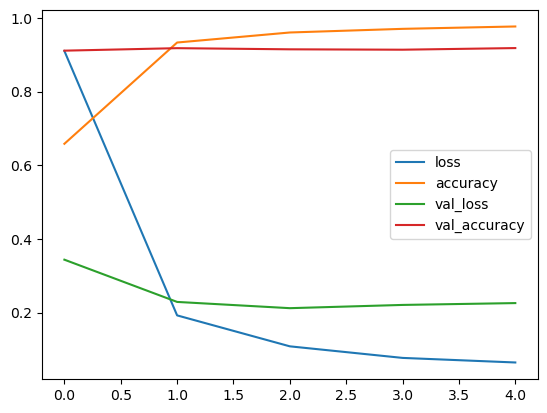

In [93]:
losses=pd.DataFrame(model.history.history)
losses.plot()

In [99]:
pred = [["it's just outrageous"],
        ["I just heard a strange noise outside; something feels off"], [" We had such a fun day"],
        ["you are the best thing in my life"], ["everything seems so dark right now"],
        ["I can't believe you celebrate a birthday party for me"]]
for text in pred:
  sequences_pred = tokenizer.texts_to_sequences(text)
  padded_pred = pad_sequences(sequences_pred, padding='post', maxlen=max_len, truncating='post')
  classes = model.predict(padded_pred)

  label = ['anger', 'fear',	'joy', 'love', 'sadness', 'surprise']
  print(text)
  print(classes)
  print(label[np.argmax(classes)])
  print()


1/1 [==============================] - 0s 38ms/step
["it's just outrageous"]
[[0.21604344 0.25373155 0.18074329 0.11731081 0.09095511 0.1412158 ]]
fear

1/1 [==============================] - 0s 36ms/step
['I just heard a strange noise outside; something feels off']
[[0.00346786 0.904045   0.00926591 0.00870452 0.00561382 0.06890287]]
fear

1/1 [==============================] - 0s 37ms/step
[' We had such a fun day']
[[0.16557142 0.20234264 0.23678386 0.19846001 0.0786705  0.11817148]]
joy

1/1 [==============================] - 0s 36ms/step
['you are the best thing in my life']
[[0.25855777 0.31793287 0.15083528 0.08882353 0.07684143 0.10700916]]
fear

1/1 [==============================] - 0s 37ms/step
['everything seems so dark right now']
[[0.05053942 0.74403185 0.05806426 0.05404048 0.03749297 0.05583102]]
fear

1/1 [==============================] - 0s 35ms/step
["I can't believe you celebrate a birthday party for me"]
[[0.3548011  0.1931779  0.11227027 0.06264161 0.15989746 0.1